# 準備

In [ ]:
!nvidia-smi

Sun Jan 31 04:41:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# バージョン指定時にコメントアウト
#!pip install torch==1.7.0
#!pip install torchvision==0.8.1

import torch
import torchvision
# バージョンの確認
print(torch.__version__) 
print(torchvision.__version__) 

1.7.0+cu101
0.8.1+cu101


In [ ]:
# 初期化
!cd '/content/'
!rm -rf '/content/input/'

In [ ]:
# Google ドライブにマウント
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# パッケージのインポート
import os
import os.path as osp
import pandas as pd
import shutil
import random
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchsummary

In [ ]:
# 設定
workers = 2
batch_size=16
nz = 100
nch_g = 32
nch_d = 32
n_epoch = 2000
lr = 0.0002
beta1 = 0.5
outf = '/content/gdrive/MyDrive/Colab Notebooks/gan_sample/chapter3/result_3_4-LSGAN'
display_interval = 500

# 保存先ディレクトリを作成
try:
    os.makedirs(outf, exist_ok=True)
except OSError as error: 
    print(error)
    pass

# 乱数のシード（種）を固定
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# データセットの作成

In [ ]:
# データセット（画像）のダウンロード
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz -P ./input/
# データセット（アノテーション）のダウンロード
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz -P ./input/

--2021-01-31 04:42:32--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘./input/images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  34.9MB/s    in 22s     

2021-01-31 04:42:55 (34.1 MB/s) - ‘./input/images.tar.gz’ saved [791918971/791918971]

--2021-01-31 04:42:55--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘./input/annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  18.0MB/s    in 1.0s    

202

In [ ]:
# データセット（画像）の解凍
!tar -zxvf ./input/images.tar.gz -C ./input
# データセット（アノテーション）の解凍
!tar -zxvf ./input/annotations.tar.gz -C ./input

ストリーミング出力は最後の 5000 行に切り捨てられました。
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotation

In [ ]:
input_dir = '/content/input/'
image_dir = osp.join(input_dir, 'images')
annotations_dir = osp.join(input_dir, 'annotations')
list_path = osp.join(annotations_dir, 'list.txt')

dataset_dir = osp.join(input_dir, 'pet')
train_dir = osp.join(dataset_dir, 'cat')

In [ ]:
cols = ['file_name', 'class_id', 'species', 'breed_id']

labels = []
with open(list_path, 'r') as f:
    lines = f.read().splitlines()
    for line in lines:
        if line.startswith('#'):
            continue
        labels.append(line.split(' '))
f.close()
labels_df = pd.DataFrame(labels, columns=cols)

In [ ]:
labels_df

file_name class_id species breed_id
0           Abyssinian_100        1       1        1
1           Abyssinian_101        1       1        1
2           Abyssinian_102        1       1        1
3           Abyssinian_103        1       1        1
4           Abyssinian_104        1       1        1
...                    ...      ...     ...      ...
7344  yorkshire_terrier_96       37       2       25
7345  yorkshire_terrier_97       37       2       25
7346  yorkshire_terrier_98       37       2       25
7347  yorkshire_terrier_99       37       2       25
7348   yorkshire_terrier_9       37       2       25

[7349 rows x 4 columns]

In [ ]:
cat_label_df = labels_df[labels_df.species=='1']
cat_label_df = cat_label_df.reset_index(drop=True)

In [ ]:
cat_label_df

file_name class_id species breed_id
0     Abyssinian_100        1       1        1
1     Abyssinian_101        1       1        1
2     Abyssinian_102        1       1        1
3     Abyssinian_103        1       1        1
4     Abyssinian_104        1       1        1
...              ...      ...     ...      ...
2366       Sphynx_95       34       1       12
2367       Sphynx_96       34       1       12
2368       Sphynx_98       34       1       12
2369       Sphynx_99       34       1       12
2370        Sphynx_9       34       1       12

[2371 rows x 4 columns]

In [ ]:
train_df = cat_label_df
# 訓練データの読み込みディクショナリに保存
for item in train_df.file_name:
    image_name = '{}.jpg'.format(item)
    image_path = osp.join(image_dir, image_name)
    
    image_save_path = osp.join(train_dir, image_name)
    os.makedirs(osp.dirname(image_save_path), exist_ok=True)
    shutil.copy(image_path, image_save_path)

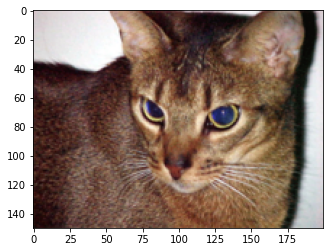

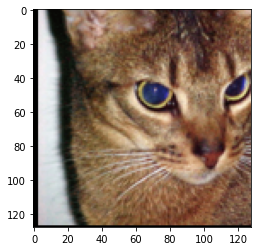

In [ ]:
#画像の読み込み
image = "./input/pet/cat/Abyssinian_5.jpg"
with open(image, 'rb') as f:
    image = Image.open(f)
    image = image.convert('RGB')

plt.figure()
plt.imshow(image)

# torchvisionのデータ拡張transformsを利用
# サイズ225でセンタークロップ
trans_image = transforms.CenterCrop(225)(image)
# サイズ128でランダムクロップ
trans_image = transforms.RandomCrop(128)(trans_image)
# 左右反転    
trans_image = transforms.RandomHorizontalFlip()(trans_image)

plt.figure()
plt.imshow(trans_image)

In [ ]:
dataset = dset.ImageFolder('./input/pet',
    transform=transforms.Compose([
    # サイズ225でセンタークロップ
    transforms.CenterCrop(225),
    # サイズ128でランダムクロップ    
    transforms.RandomCrop(128),
    # 左右反転                              
    transforms.RandomHorizontalFlip(),
    # Tensor化
    transforms.ToTensor(),
    # -1～1に値域の変更
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))        
]))

In [ ]:
# 画像配列の確認
dataset[3][0].shape

torch.Size([3, 128, 128])

In [ ]:
# 画像の域値(-1～1)の確認
dataset[3][0]

tensor([[[ 0.8039,  0.7961,  0.7882,  ...,  0.4745,  0.4745,  0.4745],
         [ 0.7882,  0.7804,  0.7725,  ...,  0.4510,  0.4588,  0.4510],
         [ 0.7647,  0.7647,  0.7647,  ...,  0.4353,  0.4275,  0.4275],
         ...,
         [-0.2392, -0.1843, -0.1529,  ...,  0.7569,  0.8118,  0.8745],
         [-0.1608, -0.1843, -0.1922,  ...,  0.7569,  0.8667,  0.8667],
         [-0.0824,  0.0275,  0.1216,  ...,  0.8510,  0.8431,  0.8431]],

        [[ 0.6549,  0.6471,  0.6392,  ...,  0.0667,  0.0667,  0.0667],
         [ 0.6392,  0.6314,  0.6235,  ...,  0.0431,  0.0510,  0.0431],
         [ 0.6157,  0.6000,  0.6000,  ...,  0.0118,  0.0196,  0.0196],
         ...,
         [-0.3255, -0.2627, -0.2314,  ...,  0.4510,  0.4353,  0.4745],
         [-0.2471, -0.2627, -0.2706,  ...,  0.4510,  0.5216,  0.5137],
         [-0.1686, -0.0353,  0.0667,  ...,  0.5608,  0.5216,  0.5216]],

        [[ 0.6235,  0.6157,  0.6078,  ...,  0.1686,  0.1608,  0.1608],
         [ 0.6078,  0.5843,  0.5765,  ...,  0

In [ ]:
# データ件数
len(dataset)

2371

In [ ]:
# 訓練データをセットしたデータローダーを作成する
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=int(workers))

# 学習に使用するデバイスを得る。可能ならGPUを使用する
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


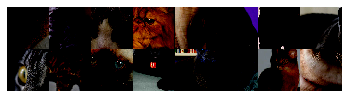

In [ ]:
#import torchvision
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

for i, (images, labels) in enumerate(dataloader):
    print(labels.numpy())
    #show(torchvision.utils.make_grid(images, nrow=5, padding=1))
    show(vutils.make_grid(images, nrow=8, padding=1))
    plt.axis('off')
    
    break

# ネットワークの定義

In [ ]:
class Generator(nn.Module):
    """
    生成器Gのクラス
    """
    def __init__(self, nz=100, nch_g=32, nch=3):
        """
        :param nz: 入力ベクトルzの次元
        :param nch_g: 最終層の入力チャネル数
        :param nch: 出力画像のチャネル数
        """
        super(Generator, self).__init__()

        # ニューラルネットワークの構造を定義する
        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.ConvTranspose2d(nz, nch_g * 16, 4, 1, 0),     # 転置畳み込み
                nn.BatchNorm2d(nch_g * 16),                      # バッチノーマライゼーション
                nn.ReLU()                                        # ReLU
            ),  # (B, nz, 1, 1) -> (B, nch_g*16, 4, 4)
            'layer1': nn.Sequential(
                nn.ConvTranspose2d(nch_g * 16, nch_g * 8, 4, 2, 1),
                nn.BatchNorm2d(nch_g * 8),
                nn.ReLU()
            ),  # (B, nch_g*16, 4, 4) -> (B, nch_g*8, 8, 8)
            'layer2': nn.Sequential(
                nn.ConvTranspose2d(nch_g * 8, nch_g * 4, 4, 2, 1),
                nn.BatchNorm2d(nch_g * 4),
                nn.ReLU()
            ),  # (B, nch_g*8, 8, 8) -> (B, nch_g*4, 16, 16)

            'layer3': nn.Sequential(
                nn.ConvTranspose2d(nch_g * 4, nch_g * 2, 4, 2, 1),
                nn.BatchNorm2d(nch_g * 2),
                nn.ReLU()
            ),  # (B, nch_g*4, 16, 16) -> (B, nch_g*2, 32, 32)
            'layer4': nn.Sequential(
                nn.ConvTranspose2d(nch_g * 2, nch_g , 4, 2, 1),
                nn.BatchNorm2d(nch_g),
                nn.ReLU()
            ),  # (B, nch_g*2, 32, 32) -> (B, nch_g, 64, 64)
            'layer5': nn.Sequential(
                nn.ConvTranspose2d(nch_g, nch, 4, 2, 1),
                nn.Tanh()
            )   # (B, nch_g, 64, 64) -> (B, nch, 128, 128)
        })

    def forward(self, z):
        """
        順方向の演算
        :param z: 入力ベクトル
        :return: 生成画像
        """
        for layer in self.layers.values():  # self.layersの各層で演算を行う
            z = layer(z)
        return z

In [ ]:
class Discriminator(nn.Module):
    """
    識別器Dのクラス
    """
    def __init__(self, nch=3, nch_d=32):
        """
        :param nch: 入力画像のチャネル数
        :param nch_d: 先頭層の出力チャネル数
        """
        super(Discriminator, self).__init__()

        # ニューラルネットワークの構造を定義する
        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.Conv2d(nch, nch_d, 4, 2, 1),     # 畳み込み
                nn.LeakyReLU(negative_slope=0.2)    # leaky ReLU関数
            ),  # (B, nch, 128, 128) -> (B, nch_d, 64, 64)
            'layer1': nn.Sequential(
                nn.Conv2d(nch_d, nch_d * 2, 4, 2, 1),
                nn.BatchNorm2d(nch_d * 2),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, nch_d, 64, 64) -> (B, nch_d*2, 32, 32)
            'layer2': nn.Sequential(
                nn.Conv2d(nch_d * 2, nch_d * 4, 4, 2, 1),
                nn.BatchNorm2d(nch_d * 4),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, nch_d*2, 32, 32) -> (B, nch_d*4, 16,16)
            'layer3': nn.Sequential(
                nn.Conv2d(nch_d * 4, nch_d * 8, 4, 2, 1),
                nn.BatchNorm2d(nch_d * 8),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, nch_d*4, 16, 16) -> (B, nch_d*8, 8, 8)
            'layer4': nn.Sequential(
                nn.Conv2d(nch_d * 8, nch_d * 16, 4, 2, 1),
                nn.BatchNorm2d(nch_d * 16),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, nch_d*8, 8, 8) -> (B, nch_d*16, 4, 4)
            'layer5':         
                nn.Conv2d(nch_d * 16, 1, 4, 1, 0)
            # (B, nch_d*16, 4, 4) -> (B, 1, 1, 1)
        })

    def forward(self, x):
        """
        順方向の演算
        :param x: 本物画像あるいは生成画像
        :return: 識別信号
        """
        for layer in self.layers.values():  # self.layersの各層で演算を行う
            x = layer(x)
        return x.squeeze()     # Tensorの形状を(B)に変更して戻り値とする

In [ ]:
import torch.nn as nn

def weights_init(m):
    """
    ニューラルネットワークの重みを初期化する。作成したインスタンスに対しapplyメソッドで適用する
    :param m: ニューラルネットワークを構成する層
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:            # 畳み込み層の場合
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:        # 全結合層の場合
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:     # バッチノーマライゼーションの場合
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
# 生成器G。ランダムベクトルから生成画像を生成する
netG = Generator(nz=nz, nch_g=nch_g).to(device)
netG.apply(weights_init)    # weights_init関数で初期化
print(netG)

Generator(
  (layers): ModuleDict(
    (layer0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer4): Sequential(
      (0): ConvTranspose2d(64, 32, ke

In [ ]:
# 生成器GのTensor形状
torchsummary.summary(netG, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,712
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,408
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,416
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,136
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13           [-1, 32, 64, 64]          32,800
      BatchNorm2d-14           [-1, 32,

In [ ]:
# 識別器D。画像が本物画像か生成画像かを識別する
netD = Discriminator(nch_d=nch_d).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (layers): ModuleDict(
    (layer0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
    (layer1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2,

In [ ]:
# 識別器DのTensor形状
torchsummary.summary(netD, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,568
         LeakyReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 32, 32]          32,832
       BatchNorm2d-4           [-1, 64, 32, 32]             128
         LeakyReLU-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 16, 16]         131,200
       BatchNorm2d-7          [-1, 128, 16, 16]             256
         LeakyReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9            [-1, 256, 8, 8]         524,544
      BatchNorm2d-10            [-1, 256, 8, 8]             512
        LeakyReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 512, 4, 4]       2,097,664
      BatchNorm2d-13            [-1, 512, 4, 4]           1,024
        LeakyReLU-14            [-1, 51

# 学習の実行

In [ ]:
criterion = nn.MSELoss()    # 損失関数は平均二乗誤差

# 生成器のエポックごとの画像生成に使用する確認用の固定ノイズ
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device) 

# オプティマイザ−のセットアップ
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [ ]:
# 学習のループ
for epoch in range(n_epoch):
    for itr, data in enumerate(dataloader):
        real_image = data[0].to(device)     # 本物画像
        sample_size = real_image.size(0)    # 画像枚数
        noise = torch.randn(sample_size, nz, 1, 1, device=device)   # 標準正規分布からノイズを生成
        
        real_target = torch.full((sample_size,), 1., device=device)     # 本物画像に対する識別信号の目標値「1」
        fake_target = torch.full((sample_size,), 0., device=device)     # 生成画像に対する識別信号の目標値「0」
        
        ############################
        # 識別器Dの更新
        ###########################
        netD.zero_grad()    # 勾配の初期化

        output = netD(real_image)   # 識別器Dで本物画像に対する識別信号を出力
        errD_real = criterion(output, real_target)  # 本物画像に対する識別信号の損失値
        D_x = output.mean().item()

        fake_image = netG(noise)    # 生成器Gでノイズから生成画像を生成
        
        output = netD(fake_image.detach())  # 識別器Dで本物画像に対する識別信号を出力
        errD_fake = criterion(output, fake_target)  #生成作画像に対する識別信号の損失値
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake    # 識別器Dの全体の損失
        errD.backward()    # 誤差逆伝播
        optimizerD.step()   # Dのパラメーターを更新

        ############################
        # 生成器Gの更新
        ###########################
        netG.zero_grad()    # 勾配の初期化
        
        output = netD(fake_image)   # 更新した識別器Dで改めて生成画像に対する識別信号を出力
        errG = criterion(output, real_target)   # 生成器Gの損失値。Dに生成画像を本物画像と誤認させたいため目標値は「1」
        errG.backward()     # 誤差逆伝播
        D_G_z2 = output.mean().item()

        optimizerG.step()   # Gのパラメータを更新

        if itr % display_interval == 0: 
            print('[{}/{}][{}/{}] Loss_D: {:.3f} Loss_G: {:.3f} D(x): {:.3f} D(G(z)): {:.3f}/{:.3f}'
                  .format(epoch + 1, n_epoch,
                          itr + 1, len(dataloader),
                          errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if epoch == 0 and itr == 0:     # 初回に本物画像を保存する
            vutils.save_image(real_image, '{}/real_samples.png'.format(outf),
                              normalize=True, nrow=8)

    ############################
    # 確認用画像の生成
    ############################
    fake_image = netG(fixed_noise)  # 1エポック終了ごとに確認用の生成画像を生成する
    vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(outf, epoch + 1),
                      normalize=True, nrow=8)

    ############################
    # モデルの保存
    ############################
    if (epoch + 1) % 100 == 0:   # 100エポックごとにモデルを保存する
        torch.save(netG.state_dict(), '{}/netG_epoch_{}.pth'.format(outf, epoch + 1))
        torch.save(netD.state_dict(), '{}/netD_epoch_{}.pth'.format(outf, epoch + 1))

[1/2000][1/149] Loss_D: 3.122 Loss_G: 27.410 D(x): 0.747 D(G(z)): 0.343/-3.215
[2/2000][1/149] Loss_D: 2.473 Loss_G: 39.144 D(x): 1.369 D(G(z)): 1.388/-5.247
[3/2000][1/149] Loss_D: 0.546 Loss_G: 0.970 D(x): 0.743 D(G(z)): -0.227/0.039
[4/2000][1/149] Loss_D: 1.448 Loss_G: 4.707 D(x): 1.332 D(G(z)): 1.004/-1.149
[5/2000][1/149] Loss_D: 0.189 Loss_G: 1.317 D(x): 0.864 D(G(z)): -0.033/-0.125
[6/2000][1/149] Loss_D: 1.163 Loss_G: 12.521 D(x): 1.489 D(G(z)): 0.865/-2.533
[7/2000][1/149] Loss_D: 0.302 Loss_G: 1.249 D(x): 1.162 D(G(z)): 0.282/-0.093
[8/2000][1/149] Loss_D: 0.129 Loss_G: 0.945 D(x): 1.100 D(G(z)): 0.272/0.038
[9/2000][1/149] Loss_D: 0.494 Loss_G: 0.725 D(x): 1.342 D(G(z)): 0.526/0.158
[10/2000][1/149] Loss_D: 0.080 Loss_G: 0.865 D(x): 0.772 D(G(z)): -0.102/0.075
[11/2000][1/149] Loss_D: 1.294 Loss_G: 0.921 D(x): 1.210 D(G(z)): 1.031/0.102
[12/2000][1/149] Loss_D: 0.066 Loss_G: 1.217 D(x): 0.999 D(G(z)): 0.217/-0.101
[13/2000][1/149] Loss_D: 0.365 Loss_G: 1.335 D(x): 1.272 D(G